In [109]:
# load data
%load_ext autoreload
import trafpy.generator as tpg
import json

path_to_benchmark_data = '../data/benchmark_data/ndf50_1s_university_benchmark_data.json'
benchmark_data = json.loads(tpg.load_data_from_json(path_to_benchmark_data))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Time to load data from ../data/benchmark_data/ndf50_1s_university_benchmark_data.json: 0.16329240798950195 s


In [110]:
# format data
%autoreload
benchmarks = list(benchmark_data.keys())
demand_data_list = []

for benchmark in benchmarks:
    for load in benchmark_data[benchmark]:
        for repeat in benchmark_data[benchmark][load]:
            demand_data = benchmark_data[benchmark][load][repeat]
            demand_data_list.append(demand_data)
            
num_sets_of_demand_data = len(demand_data_list)
print('Number of sets of demand data: {}'.format(num_sets_of_demand_data))

print('\nKeys of first demand data set:\n{}'.format(demand_data_list[0].keys()))
print('\nStructure of first demand data set:\n{}'.format(demand_data_list[0]))

Number of sets of demand data: 10

Keys of first demand data set:
dict_keys(['flow_id', 'sn', 'dn', 'flow_size', 'event_time', 'establish', 'index'])

Structure of first demand data set:
{'flow_id': ['flow_0', 'flow_1', 'flow_2', 'flow_3', 'flow_4', 'flow_5', 'flow_6', 'flow_7', 'flow_8', 'flow_9', 'flow_10', 'flow_11', 'flow_12', 'flow_13', 'flow_14', 'flow_15', 'flow_16', 'flow_17', 'flow_18', 'flow_19', 'flow_20', 'flow_21', 'flow_22', 'flow_23', 'flow_24', 'flow_25', 'flow_26', 'flow_27', 'flow_28', 'flow_29', 'flow_30', 'flow_31', 'flow_32', 'flow_33', 'flow_34', 'flow_35', 'flow_36', 'flow_37', 'flow_38', 'flow_39', 'flow_40', 'flow_41', 'flow_42', 'flow_43', 'flow_44', 'flow_45', 'flow_46', 'flow_47', 'flow_48', 'flow_49', 'flow_50', 'flow_51', 'flow_52', 'flow_53', 'flow_54', 'flow_55', 'flow_56', 'flow_57', 'flow_58', 'flow_59', 'flow_60', 'flow_61', 'flow_62', 'flow_63', 'flow_64', 'flow_65', 'flow_66', 'flow_67', 'flow_68', 'flow_69', 'flow_70', 'flow_71', 'flow_72', 'flow_7

In [123]:
# init sim objects
%autoreload
from trafpy.manager import Demand, RWA, SRPT, DCN
import config

demand_data = demand_data_list[0]

# init manager
# network = tpg.gen_simple_network(ep_label=config.ENDPOINT_LABEL,num_channels=config.NUM_CHANNELS)
network = tpg.gen_fat_tree(k=3, N=2, num_channels=1, server_to_rack_channel_capacity=1, rack_to_edge_channel_capacity=5, edge_to_agg_channel_capacity=5, agg_to_core_channel_capacity=5)
demand = Demand(demand_data=demand_data)
rwa = RWA(tpg.gen_channel_names(config.NUM_CHANNELS), config.NUM_K_PATHS)
scheduler = SRPT(network, rwa, slot_size=config.SLOT_SIZE)
env = DCN(network, demand, scheduler, slot_size=config.SLOT_SIZE, max_flows=config.MAX_FLOWS, max_time=config.MAX_TIME)


Episode 1/1
Resetting simulation 'dcn_sim'
Time: 1000.0
Action:
{'chosen_flows': [{'flow_id': 'flow_0', 'size': 229.0, 'src': 'server_6', 'dst': 'server_3', 'establish': 1, 'parent_deps': None, 'completed_parent_deps': [], 'child_deps': None, 'parent_op_run_time': None, 'time_parent_op_started': None, 'parent_op': None, 'dependency_type': None, 'child_op': None, 'can_schedule': 1, 'job_id': None, 'path': ['server_6', 'rack_3', 'edge_1', 'agg_1', 'core_0', 'agg_0', 'edge_0', 'rack_1', 'server_3'], 'channel': 'channel_1', 'packets': array([300.]), 'time_arrived': 0.0, 'time_completed': None, 'k_shortest_paths': [['server_6', 'rack_3', 'edge_1', 'agg_1', 'core_0', 'agg_0', 'edge_0', 'rack_1', 'server_3']]}]}
Machine readable network observation:
(<tf.Tensor: shape=(528, 95), dtype=float32, numpy=
array([[ 0.0000000e+00,  1.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000

Exception: 

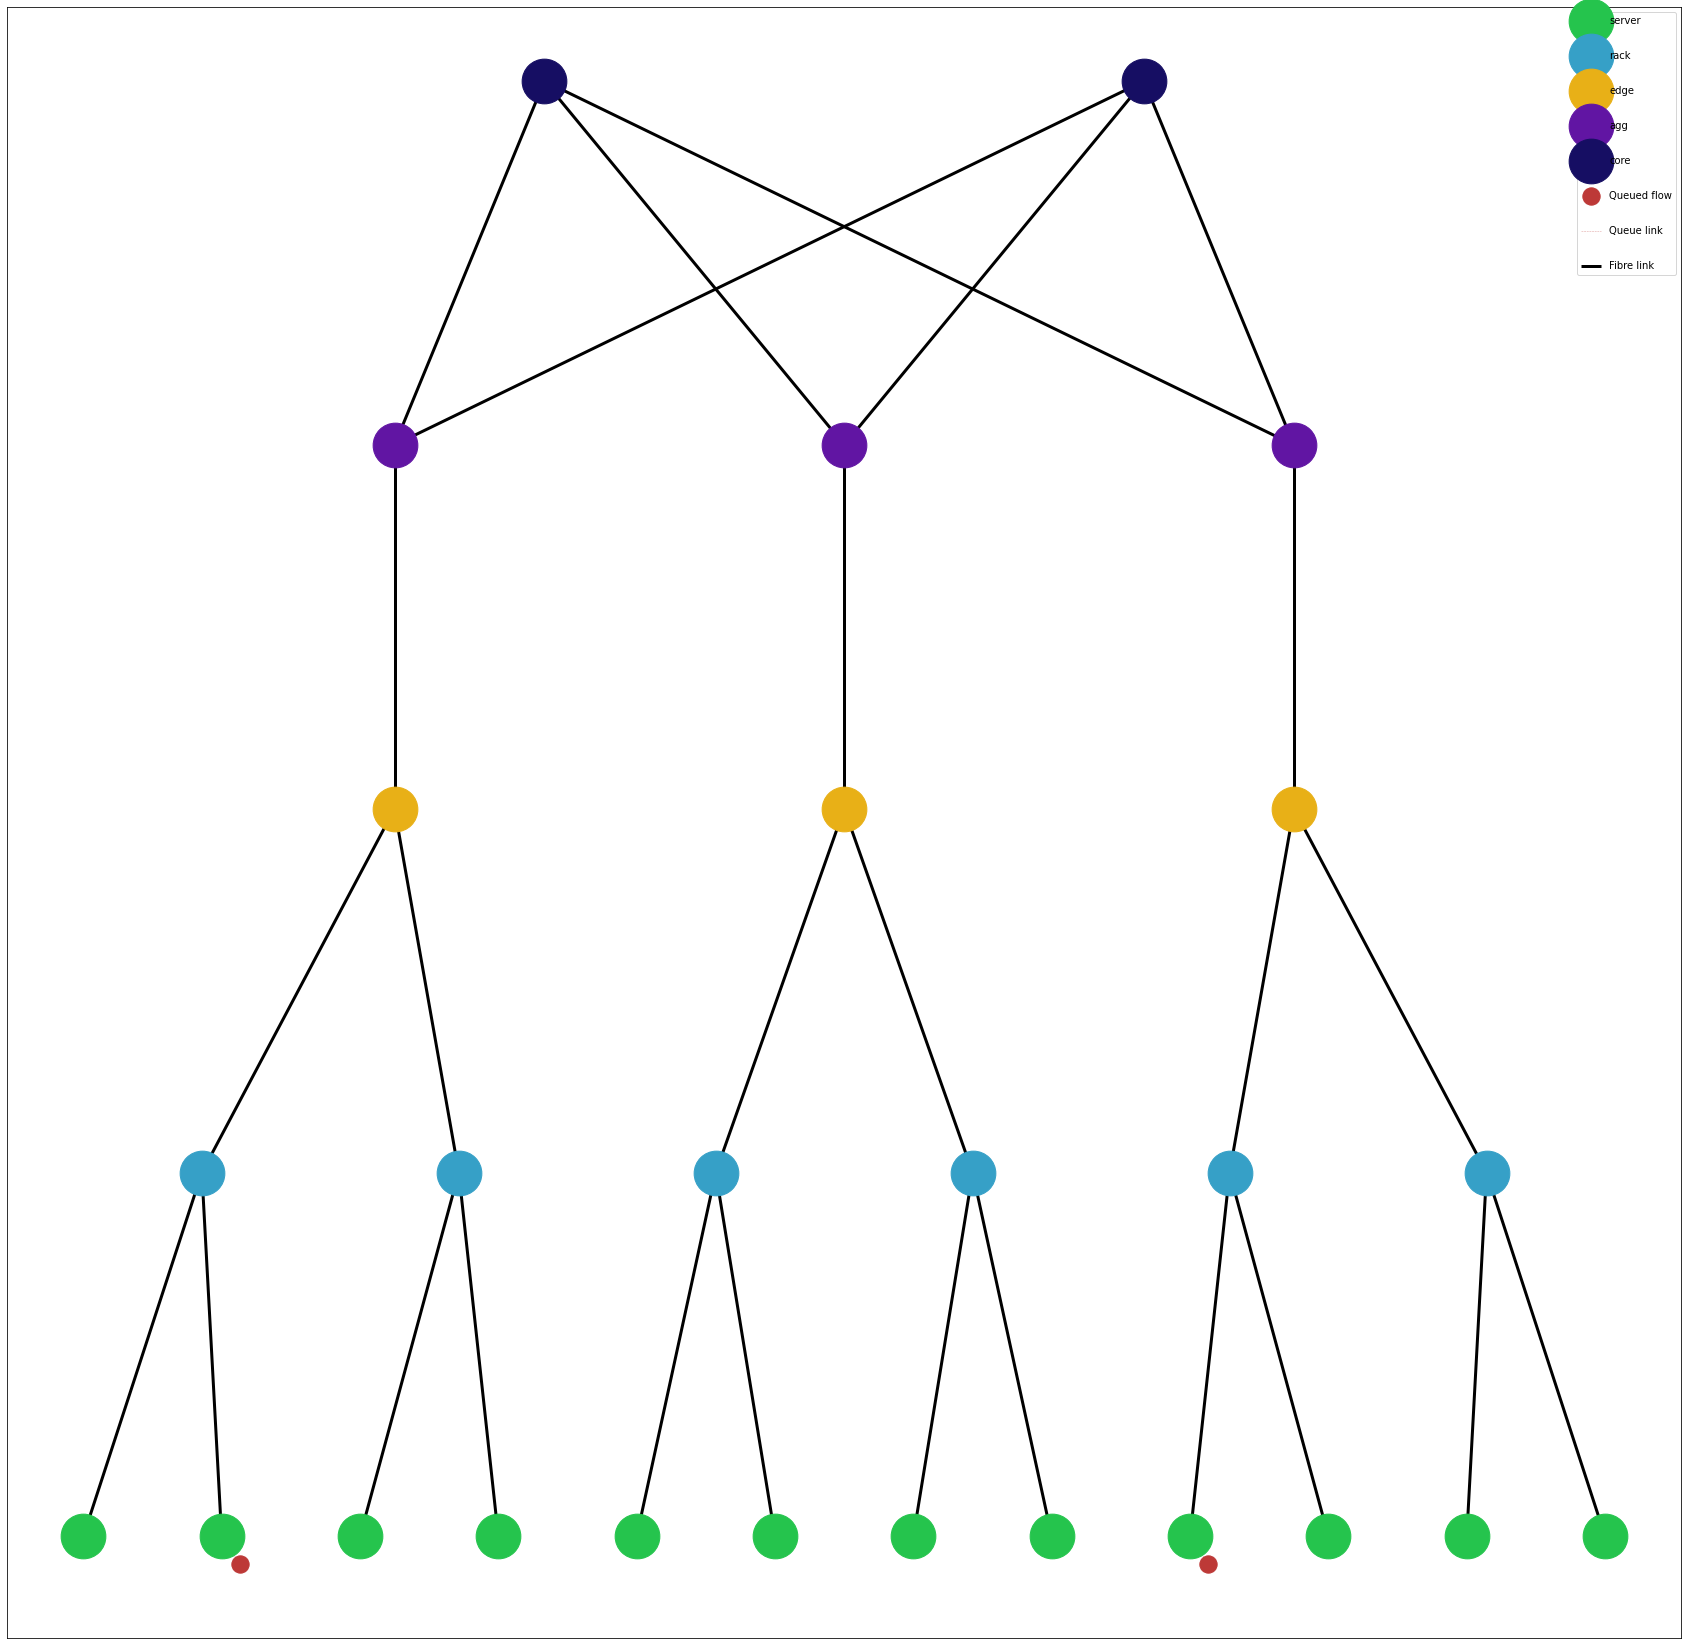

In [124]:
# run simulation
%autoreload
for episode in range(config.NUM_EPISODES):
    print('\nEpisode {}/{}'.format(episode+1,config.NUM_EPISODES))
    observation = env.reset(config.LOAD_DEMANDS)
    while True:
        print('Time: {}'.format(env.curr_time))
        action = scheduler.get_action(observation)
        print('Action:\n{}'.format(action))
        observation, reward, done, info = env.step(action)
        print('Machine readable network observation:\n{}'.format(observation['machine_readable_network']))
        
        fig, net, pos = env.draw_network_state()
        
        
        raise Exception()
        if done:
            print('Episode finished.')
            break

In [120]:
%autoreload

print(env.repgen.num_actions)
# print(observation['network'].nodes['server_1'])

AttributeError: 'RepresentationGenerator' object has no attribute 'num_actions'

In [114]:
%autoreload
import tensorflow as tf
import numpy as np
import json


class RepresentationGenerator:
    def __init__(self, env):
        self.env = env
        
        # init network params
        self.num_nodes, self.num_pairs, self.node_to_index, self.index_to_node = tpg.get_network_params(env.network.graph['endpoints'])
        self.ep_label = env.network.graph['endpoint_label']
        
        # init onehot encoding
        self.onehot_endpoints, self.endpoint_to_onehot = self.onehot_encode_endpoints()
        self.onehot_paths, self.path_to_onehot = self.onehot_encode_paths()
        
    def onehot_encode_endpoints(self):
        onehot_endpoints = tf.one_hot(indices=list(self.index_to_node.keys()), depth=self.num_nodes)
        endpoint_to_onehot = {endpoint: onehot for endpoint, onehot in zip(self.index_to_node.values(), onehot_endpoints)}
        
        return onehot_endpoints, endpoint_to_onehot
    
    def onehot_encode_paths(self):
        num_k_paths = self.env.scheduler.RWA.num_k
        all_paths = []
        for src in self.node_to_index.keys():
            for dst in self.node_to_index.keys():
                if src == dst:
                    pass
                else:
                    paths = self.env.scheduler.RWA.k_shortest_paths(self.env.network, src, dst)
                    for path in paths:
                        if path[::-1] not in all_paths and path not in all_paths:
                            all_paths.append(path)
        indices = [i for i in range(len(all_paths))]
        path_to_index = {json.dumps(path): index for path, index in zip(all_paths, indices)}
        index_to_path = {index: json.dumps(path) for index, path in zip(indices, all_paths)}
        onehot_paths = tf.one_hot(indices=list(index_to_path.keys()), depth=len(all_paths))
        path_to_onehot = {path: onehot for path, onehot in zip(index_to_path.values(), onehot_paths)}
        
        return onehot_paths, path_to_onehot        
    
    def gen_machine_readable_network_observation(self, network_observation, dtype=tf.float32):
        num_placeholder_flows = self.num_nodes * self.env.max_flows * (self.num_nodes - 1)
        num_actions = num_placeholder_flows * self.env.scheduler.RWA.num_k
        
        # init action representations with empty (no) flows
        action_indices = [i for i in range(num_actions)]
        action_dict = {index: {'src': tf.cast(tf.zeros(len(self.onehot_endpoints[0])), dtype=dtype),
                               'dst': tf.cast(tf.zeros(len(self.onehot_endpoints[0])), dtype=dtype),
                               'path': tf.cast(tf.zeros(len(self.onehot_paths[0])), dtype=dtype),
                               'size': tf.cast(-1, dtype=dtype),
                               'time_arrived': tf.cast(-1, dtype=dtype),
                               'selected': tf.cast(0, dtype=dtype),
                               'null_action': tf.cast(0, dtype=dtype),
                               'flow_present': tf.cast(0, dtype=dtype)} for index in action_indices}
        
        # go through network_observation queued flows and update action_dict representations
        action_iterator = iter(action_indices)
        for node in network_observation.nodes:
            if node[:len(self.ep_label)] == self.ep_label:
                queues = network_observation.nodes[node]
                for queue in queues.values():
                    for flow in queue['queued_flows']:
                        paths = self.env.scheduler.RWA.k_shortest_paths(self.env.network, flow['src'], flow['dst'])
                        for path in paths:
                            # each path is a separate action
                            idx = next(action_iterator)
                            action_dict[idx]['src'] = tf.cast(self.endpoint_to_onehot[flow['src']], dtype=dtype)
                            action_dict[idx]['dst'] = tf.cast(self.endpoint_to_onehot[flow['dst']], dtype=dtype)
                            try:
                                action_dict[idx]['path'] = tf.cast(self.path_to_onehot[json.dumps(path)], dtype=dtype)
                            except KeyError:
                                action_dict[idx]['path'] = tf.cast(self.path_to_onehot[json.dumps(path[::-1])], dtype=dtype)
                            action_dict[idx]['size'] = tf.cast(flow['size'], dtype=dtype)
                            action_dict[idx]['time_arrived'] = tf.cast(flow['time_arrived'], dtype=dtype)
                            action_dict[idx]['selected'] = tf.cast(0, dtype=dtype)
                            action_dict[idx]['null_action'] = tf.cast(0, dtype=dtype)
                            action_dict[idx]['flow_present'] = tf.cast(1, dtype=dtype)
            
            else:
                # flow placeholder in queue is empty
                pass
            
        # concat each action_dict key's values into single action_vector and stack all action vectors into single tensor
        action_stack = []
        for action in action_dict.keys():
            action_vector = self._stack_list_of_tensors([s for s in action_dict[action].values()], dtype=dtype)
            action_stack.append(action_vector)
        machine_readable_observation = tf.cast(action_stack, dtype=dtype)
        
        return machine_readable_observation


    def _stack_list_of_tensors(self, list_of_tensors, dtype=tf.float32):
        stacked_tensor = []
        for tensor in list_of_tensors:
            try:
                # stack each element in tensor
                for el in tensor.numpy():
                    stacked_tensor.append(el)
            except TypeError:
                # tensor only has one element
                stacked_tensor.append(tensor.numpy())
                
        return tf.cast(stacked_tensor, dtype=dtype)
        
        
        
        

rg = RepresentationGenerator(env)
machine_readable_observation = rg.gen_machine_readable_network_observation(observation['network'])
print(tf.shape(machine_readable_observation))
print(machine_readable_observation)

    

TypeError: Only integers, slices (`:`), ellipsis (`...`), tf.newaxis (`None`) and scalar tf.int32/tf.int64 tensors are valid indices, got 'network'

TODO:

- Implement RepresentationGenerator in .py file so env can have step(return_format='machine_readable') passed into it which will return machine_readable_observation
- Implement parametric action stuff so that can take in machine readable observation (num_actions x 95 matrix, where num_actions = N x f x k x (N-1) = 12 x 4 x 1 x 11 = 528 -> each of the 528 actions represents a flow placeholder (occupied or unoccupied) represented as a vector with 95 elements -> agent must take in this 528x95 observation space -> choose from which of these 1x95 vectors it whishes to schedule for current time slot)

In [28]:
print(net.nodes)
print(net.nodes['server_1'])

['core_0', 'core_1', 'rack_0', 'rack_1', 'rack_2', 'rack_3', 'rack_4', 'rack_5', 'edge_0', 'agg_0', 'edge_1', 'agg_1', 'edge_2', 'agg_2', 'server_0', 'server_1', 'server_2', 'server_3', 'server_4', 'server_5', 'server_6', 'server_7', 'server_8', 'server_9', 'server_10', 'server_11', 'flow_1', 'flow_4', 'flow_6', 'flow_5', 'flow_7', 'flow_2', 'flow_0', 'flow_3']
{'server_0': {'queued_flows': [], 'completion_times': []}, 'server_2': {'queued_flows': [], 'completion_times': []}, 'server_3': {'queued_flows': [], 'completion_times': []}, 'server_4': {'queued_flows': [], 'completion_times': []}, 'server_5': {'queued_flows': [{'flow_id': 'flow_1', 'size': 2283.0, 'src': 'server_1', 'dst': 'server_5', 'establish': 1, 'parent_deps': None, 'completed_parent_deps': [], 'child_deps': None, 'parent_op_run_time': None, 'time_parent_op_started': None, 'parent_op': None, 'dependency_type': None, 'child_op': None, 'can_schedule': 1, 'job_id': None, 'path': None, 'channel': None, 'packets': None, 'time_

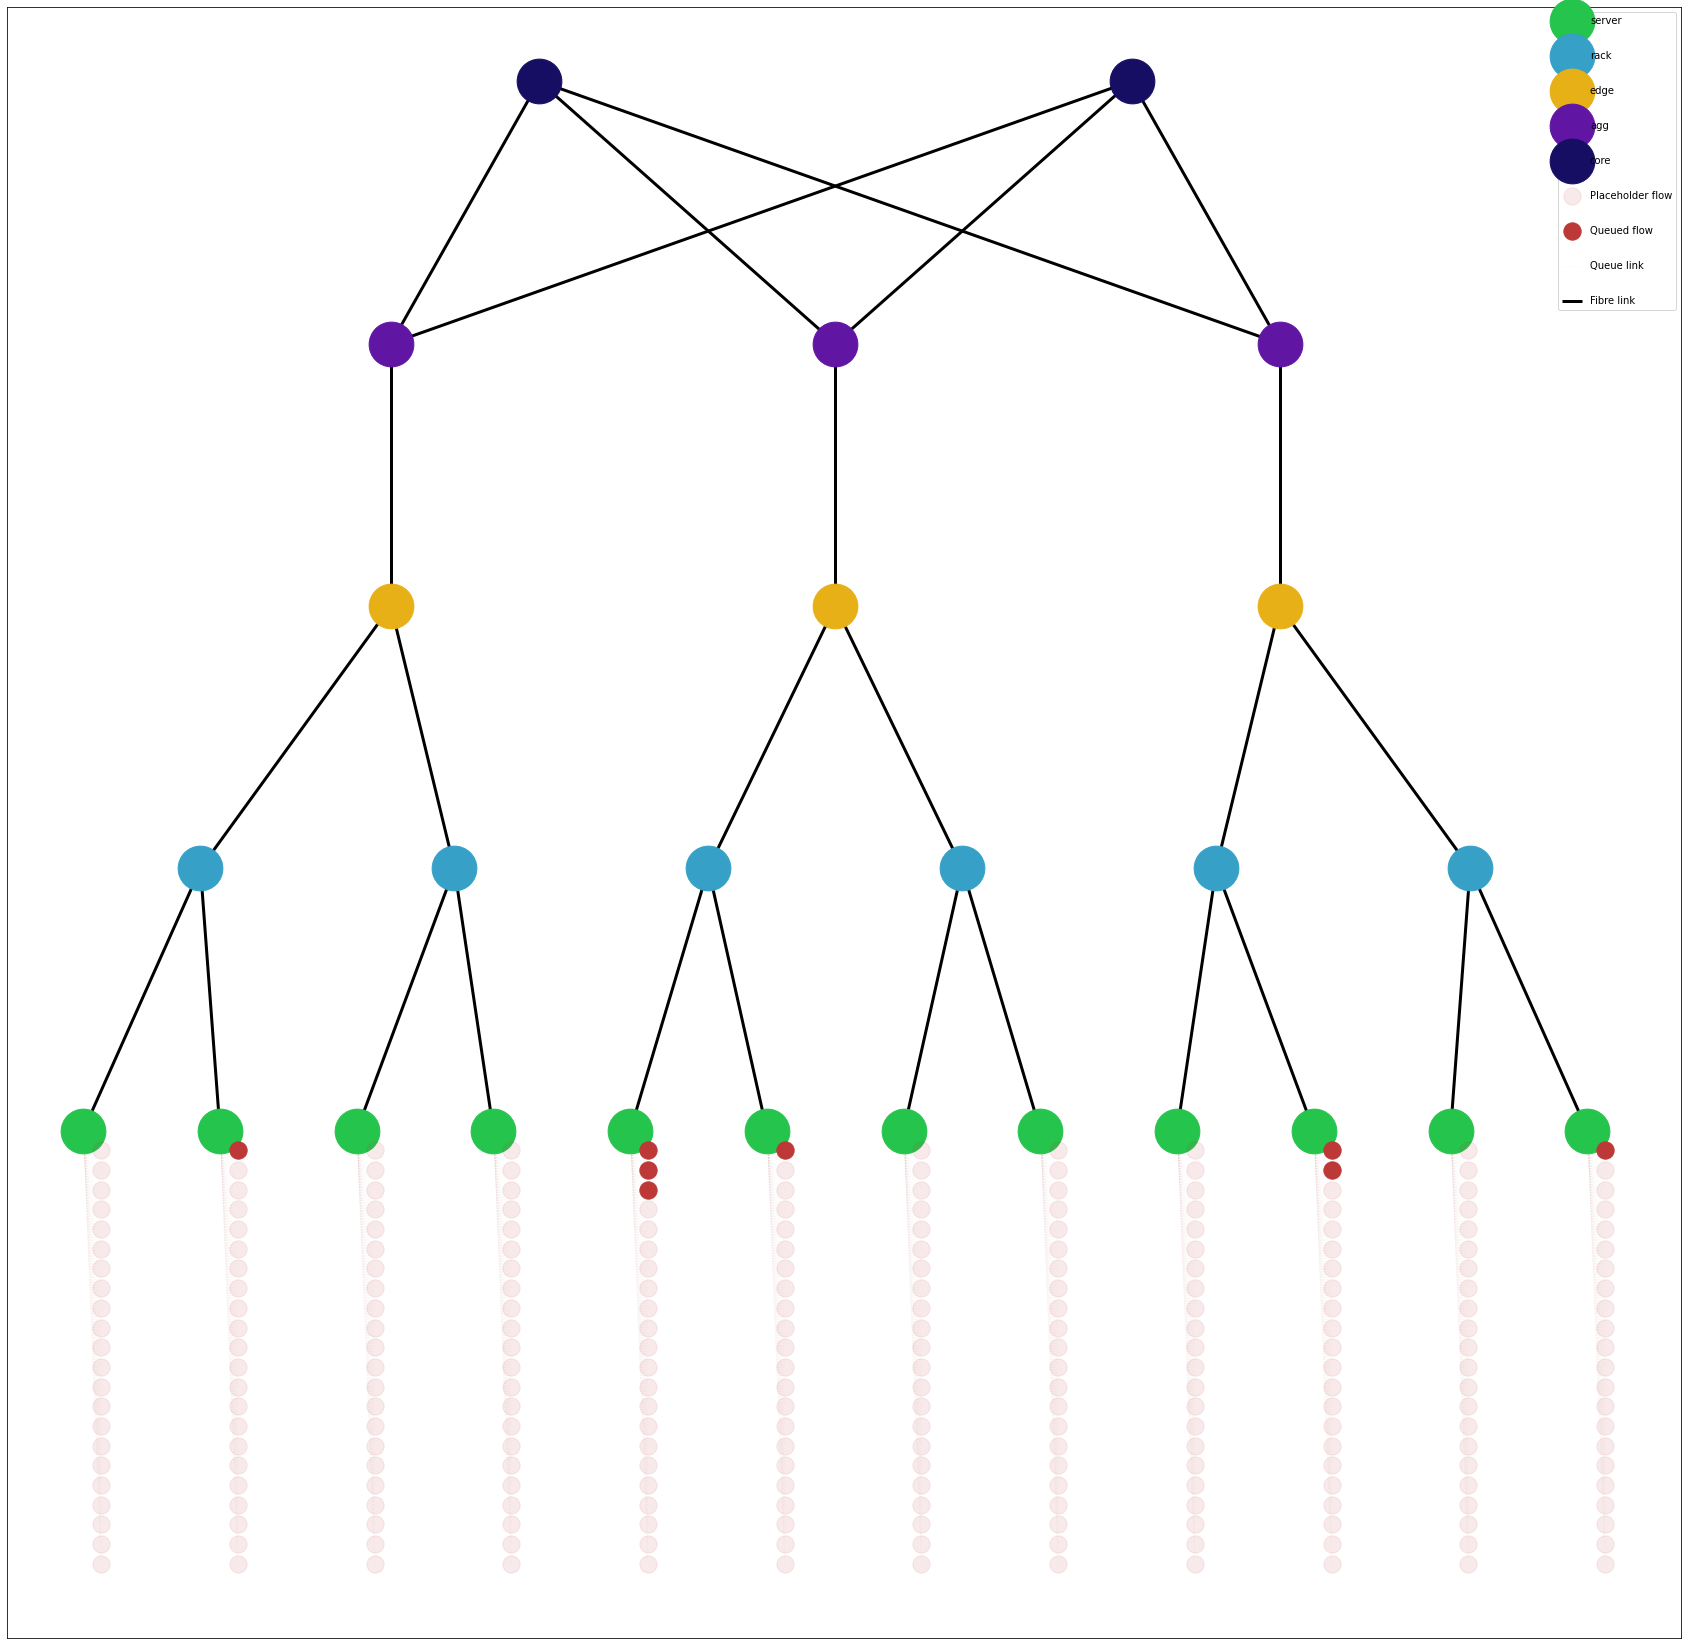

In [28]:
import matplotlib.pyplot as plt
import networkx as nx
import copy
import math


def del_all_node_attrs(net, node):
    keys_to_del = []
    for key in net.nodes[node].keys():
        keys_to_del.append(key)
    for key in keys_to_del:
        del net.nodes[node][key]
    
    return net


def gen_agent_abstract_state_representation(agent_net, env_net, slot_size, max_F, size_norm_limits=None):
    agent_net = copy.deepcopy(agent_net)
    
    empty_flow_nodes = []
    occupied_flow_nodes = []
    for node in env_net.nodes:
        if node[:4] == 'core':
            agent_net.nodes[node].update({'null_action': 1})
        elif node[:3] == 'agg':
            agent_net.nodes[node].update({'null_action': 1})
        elif node[:4] == 'edge':
            agent_net.nodes[node].update({'null_action': 1})
        elif node[:4] == 'rack':
            agent_net.nodes[node].update({'null_action': 1})
        elif node[:6] == 'server':
            server_flow_nodes = iter([n for n in agent_net.neighbors(node) if n[:4] == 'flow'])
            env_ep_queues = env_net.nodes[node]
            for env_ep_queue in env_ep_queues.values():
                for env_flow in env_ep_queue['queued_flows']:
                    agent_flow_node = next(server_flow_nodes)
                    occupied_flow_nodes.append(agent_flow_node)
                    
                    # flow path
                    agent_net.nodes[agent_flow_node].update({'path': []})
                    
                    # flow size
                    size = env_flow['size']
                    if size_norm_limits is None:
                        pass
                    else:
                        size = (size - size_norm_limits[0])/(size_norm_limits[1]-size_norm_limits[0])
                    agent_net.nodes[agent_flow_node].update({'size': size})
                    
                    # flow arrival time
                    time_slot_arrived = math.floor(env_flow['time_arrived']/slot_size)
                    agent_net.nodes[agent_flow_node].update({'time_slot_arrived': time_slot_arrived})
                    
                    # flow selection state
                    agent_net.nodes[agent_flow_node].update({'selected': 0})
                    
                    # flow null action state
                    agent_net.nodes[agent_flow_node].update({'null_action': 0})
                    
            # register remaining agent flow nodes as empty
            while True:
                try:
                    empty_flow_nodes.append(next(server_flow_nodes))
                except StopIteration:
                    break
                    
            agent_net = del_all_node_attrs(agent_net, node)
            agent_net.nodes[node].update({'null_action': 1})
            
    return agent_net, empty_flow_nodes, occupied_flow_nodes




def draw_network_state(net,
                       max_F=2,
                       draw_flows=True,
                       draw_ops=True,
                       draw_node_labels=False,
                       ep_label='server',
                       appended_node_size=300, 
                       network_node_size=2000,
                       appended_node_x_spacing=5,
                       appended_node_y_spacing=0.75,
                       font_size=15, 
                       linewidths=1, 
                       fig_scale=2):
    '''
    Draws network state as matplotlib figure
    '''

    net_node_positions = tpg.init_network_node_positions(copy.deepcopy(net))
    network = copy.deepcopy(net)

    fig = plt.figure(figsize=[15*fig_scale,15*fig_scale])

    # add nodes and edges
    pos = {}
    flows = []
    network_nodes = []
    ops = []
    network_nodes_dict = tpg.get_node_type_dict(network, net.graph['node_labels'])
    for nodes in list(network_nodes_dict.values()):
        for network_node in nodes:
            pos[network_node] = net_node_positions[network_node]

    eps = network.graph['endpoints']
    flow_nodes_added = 0
    for ep in eps:
        ep_queues = network.nodes[ep]
        y_offset = -appended_node_y_spacing
        for ep_queue in ep_queues.values():
            for flow in range(max_F):
                f_id = str('flow_node_'+str(flow_nodes_added))
                flow_nodes_added += 1
                network.add_node(f_id)
                network.add_edge(f_id, str(ep), type='queue_link')
                flows.append(f_id)
                pos[f_id] = (list(pos[str(ep)])[0]+appended_node_x_spacing, list(pos[str(ep)])[1]+y_offset)
                y_offset-=appended_node_y_spacing

    if env.demand.job_centric:
        for ep in eps:
            y_offset = -appended_node_y_spacing
            for op in env.running_ops.keys():
                op_machine = env.running_ops[op]
                if ep == op_machine:
                    network.add_node(op)
                    network.add_edge(op, op_machine, type='op_link')
                    ops.append(op)
                    pos[op] = (list(pos[op_machine])[0]-appended_node_x_spacing, list(pos[op_machine])[1]+y_offset)
                    y_offset-=appended_node_y_spacing
                else:
                    # op not placed on this end point machine
                    pass
    
    # use network to generate abstract representation for agent
    network, empty_flow_nodes, occupied_flow_nodes = gen_agent_abstract_state_representation(agent_net=network, env_net=env.network, slot_size=1e3, max_F=2, size_norm_limits=[1e0,1e7])
                
                
                
                

    # find edges
    fibre_links = []
    queue_links = []
    op_links = []
    for edge in network.edges:
        if 'channels' in network[edge[0]][edge[1]].keys():
            # edge is a fibre link
            fibre_links.append(edge)
        elif network[edge[0]][edge[1]]['type'] == 'queue_link':
            # edge is a queue link
            queue_links.append(edge)
        elif network[edge[0]][edge[1]]['type'] == 'op_link':
            # edge is a queue link
            op_links.append(edge)
        else:
            sys.exit('Link type not recognised.')

    # network nodes
    node_colours = iter(['#25c44d', '#36a0c7', '#e8b017', '#6115a3', '#160e63']) # server, rack, edge, agg, core
    for node_type in net.graph['node_labels']:
        nx.draw_networkx_nodes(network, 
                               pos, 
                               nodelist=network_nodes_dict[node_type],
                               node_size=network_node_size, 
                               node_color=next(node_colours), 
                               linewidths=linewidths, 
                               label=node_type)
        
    if draw_flows:
        # flows
        nx.draw_networkx_nodes(network, 
                               pos, 
                               nodelist=empty_flow_nodes,
                               node_size=appended_node_size, 
                               node_color='#bd3937', # #faeeed
                               alpha=0.1,
                               linewidths=linewidths, 
                               label='Placeholder flow')
        nx.draw_networkx_nodes(network, 
                               pos, 
                               nodelist=occupied_flow_nodes,
                               node_size=appended_node_size, 
                               node_color='#bd3937', 
                               linewidths=linewidths, 
                               label='Queued flow')
        # queue links
        nx.draw_networkx_edges(network, 
                               pos,
                               edgelist=queue_links,
                               edge_color='#bd3937',
                               alpha=0.05,
                               width=0.5,
                               style='dashed',
                               label='Queue link')

    if draw_ops and env.demand.job_centric:
        # ops
        nx.draw_networkx_nodes(network, 
                               pos, 
                               nodelist=ops,
                               node_size=appended_node_size, 
                               node_color='#1e9116', 
                               linewidths=linewidths, 
                               label='Running op')
        # op links
        nx.draw_networkx_edges(network, 
                               pos,
                               edgelist=op_links,
                               edge_color='#1e9116',
                               alpha=0.5,
                               width=0.5,
                               style='dashed',
                               label='Op link')




    # fibre links
    nx.draw_networkx_edges(network, 
                           pos,
                           edgelist=fibre_links,
                           edge_color='k',
                           width=3,
                           label='Fibre link')

    if draw_node_labels:
        # nodes
        nx.draw_networkx_labels(network, 
                                pos, 
                                font_size=font_size, 
                                font_color='k', 
                                font_family='sans-serif', 
                                font_weight='normal', 
                                alpha=1.0)

    plt.legend(labelspacing=2.5)

    return fig, network, pos

fig, net, pos = draw_network_state(env.network)

In [26]:
print(net.nodes)
print(net.nodes['flow_node_22'])

['core_0', 'core_1', 'rack_0', 'rack_1', 'rack_2', 'rack_3', 'rack_4', 'rack_5', 'edge_0', 'agg_0', 'edge_1', 'agg_1', 'edge_2', 'agg_2', 'server_0', 'server_1', 'server_2', 'server_3', 'server_4', 'server_5', 'server_6', 'server_7', 'server_8', 'server_9', 'server_10', 'server_11', 'flow_node_0', 'flow_node_1', 'flow_node_2', 'flow_node_3', 'flow_node_4', 'flow_node_5', 'flow_node_6', 'flow_node_7', 'flow_node_8', 'flow_node_9', 'flow_node_10', 'flow_node_11', 'flow_node_12', 'flow_node_13', 'flow_node_14', 'flow_node_15', 'flow_node_16', 'flow_node_17', 'flow_node_18', 'flow_node_19', 'flow_node_20', 'flow_node_21', 'flow_node_22', 'flow_node_23', 'flow_node_24', 'flow_node_25', 'flow_node_26', 'flow_node_27', 'flow_node_28', 'flow_node_29', 'flow_node_30', 'flow_node_31', 'flow_node_32', 'flow_node_33', 'flow_node_34', 'flow_node_35', 'flow_node_36', 'flow_node_37', 'flow_node_38', 'flow_node_39', 'flow_node_40', 'flow_node_41', 'flow_node_42', 'flow_node_43', 'flow_node_44', 'flow_

In [124]:
import copy 
import math

def del_all_node_attrs(net, node):
    keys_to_del = []
    for key in net.nodes[node].keys():
        keys_to_del.append(key)
    for key in keys_to_del:
        del net.nodes[node][key]
    
    return net


def gen_agent_abstract_state_representation(net, slot_size, max_F, size_norm_limits=None):
    relabelled_net = copy.deepcopy(net)
    
    empty_flow_nodes = 0
    for node in relabelled_net.nodes:
        if node[:4] == 'core':
            relabelled_net.nodes[node].update({'null_action': 1})
        elif node[:3] == 'agg':
            relabelled_net.nodes[node].update({'null_action': 1})
        elif node[:4] == 'edge':
            relabelled_net.nodes[node].update({'null_action': 1})
        elif node[:4] == 'rack':
            relabelled_net.nodes[node].update({'null_action': 1})
        elif node[:6] == 'server':
            ep_queues = relabelled_net.nodes[node]
            for ep_queue in ep_queues.values():
                for flow in ep_queue['queued_flows']:
                    # flow path
                    relabelled_net.nodes[flow['flow_id']].update({'path': []})
                    
                    # flow size
                    size = flow['size']
                    if size_norm_limits is None:
                        pass
                    else:
                        size = (size - size_norm_limits[0])/(size_norm_limits[1]-size_norm_limits[0])
                    relabelled_net.nodes[flow['flow_id']].update({'size': size})
                    
                    # flow arrival time
                    time_slot_arrived = math.floor(flow['time_arrived']/slot_size)
                    relabelled_net.nodes[flow['flow_id']].update({'time_slot_arrived': time_slot_arrived})
                    
                    # flow selection state
                    relabelled_net.nodes[flow['flow_id']].update({'selected': 0})
                    
                    # flow null action state
                    relabelled_net.nodes[flow['flow_id']].update({'null_action': 0})
                    
                num_flows_in_queue = len(ep_queue['queued_flows'])
                    
                    
                
                
                    
            relabelled_net = del_all_node_attrs(relabelled_net, node)
            relabelled_net.nodes[node].update({'null_action': 1})
            
    return relabelled_net
            
        
abstract_net = gen_agent_abstract_state_representation(env.network, slot_size=1e3, max_F=2, size_norm_limits=[1e0,1e7])

KeyError: 'flow_1'

In [103]:
for node in abstract_net.nodes:
    print(node)
    print(abstract_net.nodes[node])

core_0
{'null_action': 1}
core_1
{'null_action': 1}
rack_0
{'null_action': 1}
rack_1
{'null_action': 1}
rack_2
{'null_action': 1}
rack_3
{'null_action': 1}
rack_4
{'null_action': 1}
rack_5
{'null_action': 1}
edge_0
{'null_action': 1}
agg_0
{'null_action': 1}
edge_1
{'null_action': 1}
agg_1
{'null_action': 1}
edge_2
{'null_action': 1}
agg_2
{'null_action': 1}
server_0
{'null_action': 1}
server_1
{'null_action': 1}
server_2
{'null_action': 1}
server_3
{'null_action': 1}
server_4
{'null_action': 1}
server_5
{'null_action': 1}
server_6
{'null_action': 1}
server_7
{'null_action': 1}
server_8
{'null_action': 1}
server_9
{'null_action': 1}
server_10
{'null_action': 1}
server_11
{'null_action': 1}
flow_1
{'path': [], 'size': 0.00022820002282000228, 'time_slot_arrived': 0, 'selected': 0, 'null_action': 0}
flow_4
{'path': [], 'size': 2.9400002940000294e-05, 'time_slot_arrived': 1, 'selected': 0, 'null_action': 0}
flow_6
{'path': [], 'size': 0.00012510001251000126, 'time_slot_arrived': 1, 'select